# TIME SERIES FORECAST - PERFORMANCE

In this notebook, we forecast the temperature of the 100 months after the training data using an LSTM depoyed model.
We trained the model on data to 2005 and forecast data from 2005 to 2013.

In the second part of the notebook, we visualize the predictions and assess the performance with metrics

### Import modules

In [1]:
from TimeSeriesAnalysis.forecast_model import TimeSeriesForecast
import requests
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
from scipy import stats
import torch

from TimeSeriesAnalysis.features import feature_engineering
from TimeSeriesAnalysis.utils import calculate_metrics

import matplotlib.pyplot as plt
# Set global settings for all plots
plt.rcParams["font.size"] = 18
plt.rcParams["font.family"] = "serif"


2024-10-02 15:06:10.103 | INFO     | TimeSeriesAnalysis.config:<module>:10 - PROJ_ROOT path is: /usr/local/lib/python3.10/site-packages


#### Define parameters

In [2]:
future_steps = 100
test_data_path = "data/GlobalLandTemperatures_US_test.csv"
train_data_path = "data/GlobalLandTemperatures_US_train.csv"
model_type = "LSTM"

## FORECAST WITH DEPLOYED MODEL

We forecast the 100 temperatures from 2005 to 2013 using a deployed LSTM model, which has been logged in MLflow.

#### Loading the model

In [4]:
#The model corresponds to version 2 in "TEMPERATURE_FORECAST" MLFlow registering
model_path = "ML_artifacts/model.pth"
deployed_model = torch.load(model_path)

/tmp/ipykernel_12/861393760.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deployed_model = torch.load(model_path)


In [5]:
model = TimeSeriesForecast(model_type="LSTM")
model.load_model(deployed_model)

#### During predictions, we load the training data to ensure continuity, as the model will forecast the subsequent years immediately following the training period.

In [6]:
# preprocess training data
df = pd.read_csv(train_data_path)
temp_series = feature_engineering(df, model_type="LSTM")

2024-10-02 15:06:23.864 | INFO     | TimeSeriesAnalysis.features:feature_engineering:12 - Starting feature engineering...
2024-10-02 15:06:23.880 | INFO     | TimeSeriesAnalysis.features:feature_engineering:25 - Cleaning dataframe of years with missing data...
2024-10-02 15:06:23.885 | INFO     | TimeSeriesAnalysis.features:feature_engineering:34 - Dataset ready...


In [7]:
forecast_values = model.predict(data=temp_series.values, future_steps=future_steps)

2024-10-02 15:07:43.112 | INFO     | TimeSeriesAnalysis.forecast_model:predict:117 - Making predictions for 100 future steps...


## VISUALIZE FORECAST

In [8]:
# laod the actual data for comparison and performacen assessment
df_test = pd.read_csv(test_data_path)
temp_series_test = feature_engineering(df_test, model_type=model_type)
temp_series_test = temp_series_test[:future_steps]

2024-10-02 15:07:54.931 | INFO     | TimeSeriesAnalysis.features:feature_engineering:12 - Starting feature engineering...
2024-10-02 15:07:54.940 | INFO     | TimeSeriesAnalysis.features:feature_engineering:25 - Cleaning dataframe of years with missing data...
2024-10-02 15:07:54.943 | INFO     | TimeSeriesAnalysis.features:feature_engineering:34 - Dataset ready...


####  Plot 1: Forecast and measurements comparison

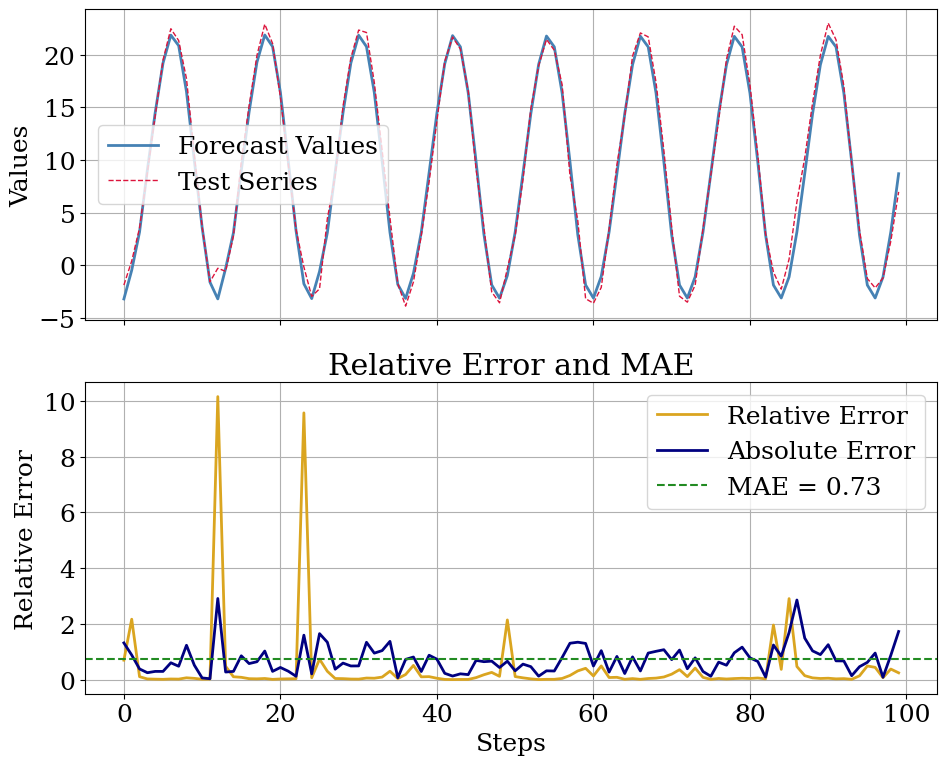

In [9]:
steps = np.arange(0, 100, 1)

# Calculate relative error and MAE
relative_error = np.abs(forecast_values - temp_series_test) / np.abs(temp_series_test)
ae = np.abs(forecast_values - temp_series_test)
mae = np.mean(ae)

fig, ax1 = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# First panel: Plot forecast values and test series
ax1[0].plot(steps, forecast_values, label="Forecast Values", color="steelblue", linewidth=2)
ax1[0].plot(steps, temp_series_test, label="Test Series", color="crimson", linewidth=1, ls="--")
ax1[0].set_ylabel("Values")
ax1[0].legend()
ax1[0].grid(True)

# Second panel: Plot relative error and absolute error
ax1[1].plot(steps, relative_error, label="Relative Error", color="goldenrod", linewidth=2)
ax1[1].plot(steps, ae, label="Absolute Error", color="navy", linewidth=2)

ax1[1].axhline(mae, color="forestgreen", linestyle="--", label=f"MAE = {mae:.2f}")
ax1[1].set_title("Relative Error and MAE")
ax1[1].set_xlabel("Steps")
ax1[1].set_ylabel("Relative Error")
ax1[1].legend()
ax1[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

The relative error is close to zero in most cases, however there are also predicted values with very large errors. Comparing with the top plot, we see that these correspond to temperature values near zero, where relative error is not a convenient metric. The blue line corresponds to the absolute error, which is displays a more stable behaviour. 

#### General Metrics:

In [10]:
# Run the metric calculations
metrics_results = calculate_metrics(temp_series_test, forecast_values)
for metric, value in metrics_results.items():
    print(f"{metric}: {value:.4f}")

MAE: 0.7274
MSE: 0.7998
RMSE: 0.8943
R-squared: 0.9899


The MAE, MSE and RMSE show values <1, which indicate that we at leat have reasonable predictions. However, it is difficult tu assess how good these are without a proper benchmark. We could use them to compare different models.
The R-squared value close to one indicates a good fit between forecast and true temperatures

#### Plot 2: scatter plot

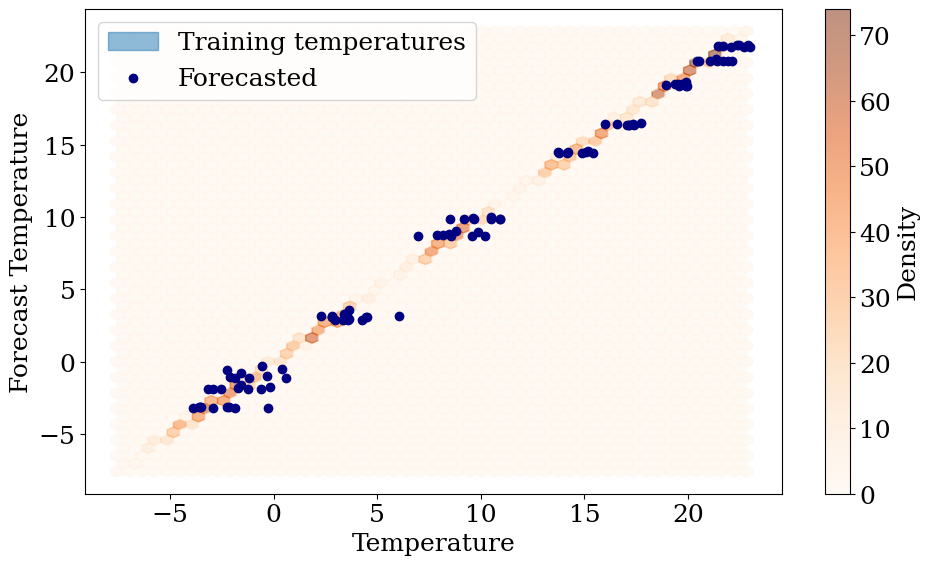

In [11]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot actual temperature values as a density scatter plot
hb =plt.hexbin(temp_series, temp_series, gridsize=50, cmap='Oranges', alpha=0.5, label='Training temperatures')
plt.scatter(temp_series_test,forecast_values, color='navy', label ='Forecasted')

cb = plt.colorbar(hb, label='Density')
plt.xlabel("Temperature")
plt.ylabel("Forecast Temperature")

plt.legend()
plt.tight_layout()
plt.show()

This plot reveals that the forecasted temperatures are not smoothly distributed but tend to cluster within specific temperature ranges. This suggests that temperature variations in the data are not gradual over time, with sharp changes dominating the trends observed in the training set. These abrupt shifts are particularly evident in the density plot, where the forecasted values cluster around the most densely populated regions.

The observed distribution pattern is likely influenced by the fact that the temperature data is averaged monthly. This aggregation smooths out less common intermediate temperature values, causing more extreme or representative temperatures to dominate, while subtle variations are minimized in the process.

#### Plot 3: Cumulative error plot

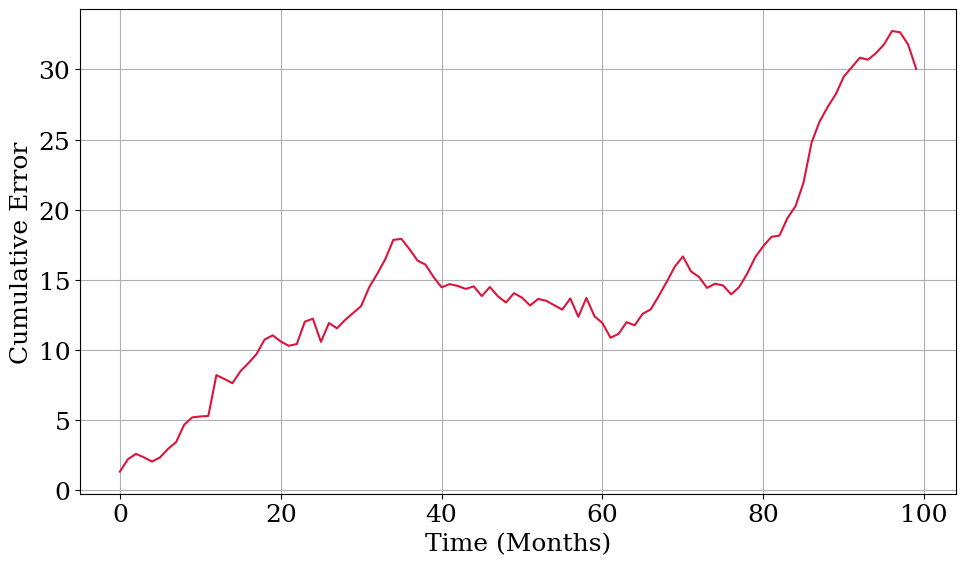

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate errors (difference between actual and forecasted values)
errors = temp_series_test - forecast_values

# Calculate cumulative errors
cumulative_errors = np.cumsum(errors)

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot cumulative errors
plt.plot(np.arange(100), cumulative_errors, color='crimson', label='Cumulative Error')

# Add labels and title
plt.xlabel('Time (Months)')
plt.ylabel('Cumulative Error')

# Add grid and legend
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.show()


The cumulative error plot indicates no clear biases, although the model tends to overestimate temperature.

#### Plot 4: Checking if there are patterns in forecast accuracy across different periods, such as seasonal biases

In [13]:
# Create a date range starting from January 2005 for the length of forecast_values
date_range = pd.date_range(start='2004-01-01', periods=len(forecast_values), freq='M')

forecast_df = pd.DataFrame({
    'Date': date_range,
    'Forecast': forecast_values
})

forecast_df['Year'] = forecast_df['Date'].dt.year
forecast_df['Month'] = forecast_df['Date'].dt.month

forecast_df.set_index('Date', inplace=True)

forecast_df['Temperature'] = temp_series_test.values
forecast_df['Error'] = np.abs(temp_series_test.values - forecast_values)
print(forecast_df.head())  

             Forecast  Year  Month  Temperature     Error
Date                                                     
2004-01-31  -3.203844  2004      1       -1.884  1.319844
2004-02-29  -0.477301  2004      2        0.408  0.885301
2004-03-31   3.159717  2004      3        3.548  0.388283
2004-04-30   9.048876  2004      4        8.797  0.251876
2004-05-31  14.502978  2004      5       14.204  0.298978


/tmp/ipykernel_12/3875109377.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start='2004-01-01', periods=len(forecast_values), freq='M')


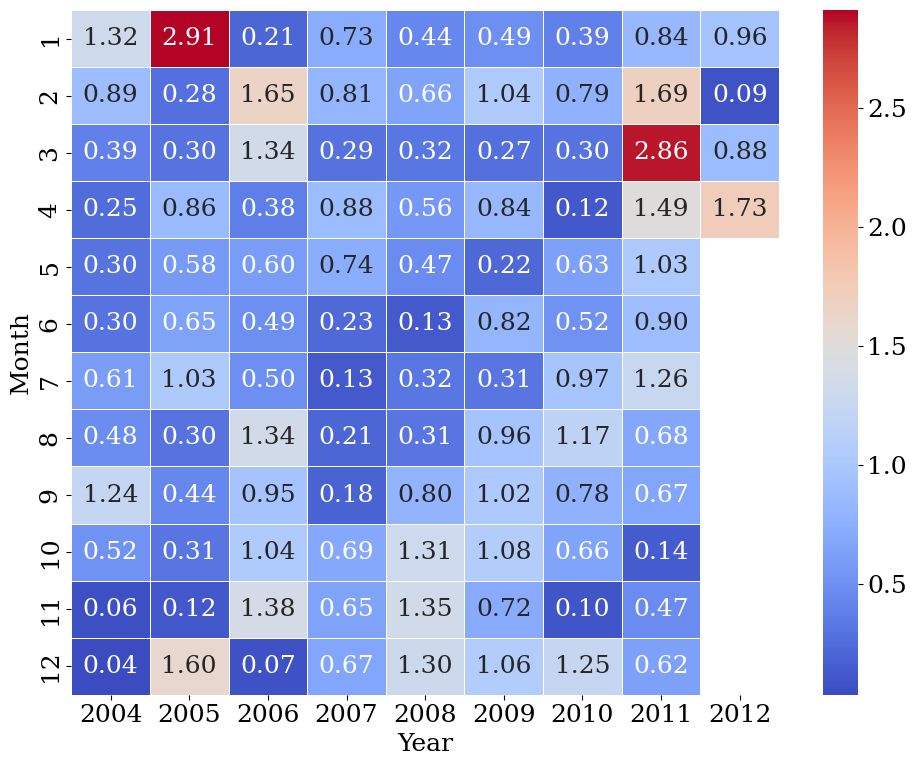

In [14]:
# Pivot the data 
heatmap_data = forecast_df.pivot_table(index='Month', columns='Year', values='Error', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

plt.xlabel('Year')
plt.ylabel('Month')

plt.tight_layout()
plt.show()


We do not see a strong errors correlation with season. Results in January and December could indicate that the model straggles more forecasting negative temperatures.

#### Plot 4: Checking if there are patterns in forecast accuracy across different periods, such as seasonal biases

In this plot, we aim to test if the model is capable of learning the warming trends (potentially casued by global warming) which is much more subtle than seasonal trends

In [ ]:
forecast_values = model.predict(data=temp_series.values, future_steps=1008)

2024-10-02 15:07:59.746 | INFO     | TimeSeriesAnalysis.forecast_model:predict:117 - Making predictions for 1008 future steps...


We are now forecasting 1000 future temperature values and averaging these predictions over multiple years. Since there are no recorded temperatures for this period, the primary objective is to determine whether the trends observed in the training data are reflected in the forecasted values.

In [ ]:
# Create a date range starting from January 2005 for the length of forecast_values
date_range = pd.date_range(start='2004-01-01', periods=len(forecast_values), freq='M')

forecast_df = pd.DataFrame({
    'Date': date_range,
    'Forecast': forecast_values
})

forecast_df['Year'] = forecast_df['Date'].dt.year
forecast_df['Month'] = forecast_df['Date'].dt.month

forecast_df.set_index('Date', inplace=True)
print(forecast_df.head())  

In [ ]:

# Compute yearly average temperatures
df_yearly_avg = forecast_df.groupby("Year").agg({"Forecast": "mean"}).reset_index()

# Fit a linear regression to the yearly average temperature data
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_yearly_avg.dropna()["Year"], df_yearly_avg.dropna()["Forecast"].values
)

# Predicted values for the trend line
trendline = intercept + slope * df_yearly_avg["Year"]

# Plot the yearly average temperatures and the trendline
plt.figure(figsize=(10, 5))
plt.plot(
    df_yearly_avg["Year"],
    df_yearly_avg["Forecast"],
    color="crimson",
    label="Average Forecasted Temperature",
)
plt.plot(
    df_yearly_avg["Year"],
    trendline,
    linestyle="--",
    label=f"linear fit (slope={slope:.4f})",
    color="navy",
)

plt.xlabel("Year")
plt.ylabel("Average Forecasted Temperature", fontsize=14)
plt.grid(True)

plt.ylim(-4,12)

plt.savefig(FIGURES_DIR / "AvTemp_allYears_with_trendline_forecast.png", bbox_inches="tight")
plt.show()

This is not capturing the trend, although it is not supresing since the model is using time steps of two years, which are not enough to capture the global warming trend. 

We also tested a longer time step, but did not result in a better long-term performance. Further investigaton would be required. 